# random walk

In una torrida giornata di luglio, in un villaggio sperduto in Armorica, il druido Panoramix sbagliò ricetta ed invece della solita pozione magica produsse, nel suo calderone, la grappa più alcolica mai distillata in Gallia.

 * Si scriva una funzione che simuli il passo degli abitanti del villaggio dopo aver bevuto la grappa, assumendo che abbia direzione casuale uniforme ed una lunghezza casuale secondo una distribuzione Gaussiana con media 1 e larghezza 0.2, troncata a valori positivi.

In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from lib import try_and_catch_step

N_galois = 10000 # numero di abitanti del villaggio
N_steps_galois = 10

 * Immaginando che il calderone si trovi alle coordinate $(0,0)$ sul piano, si scriva una funzione che calcoli la posizione $(x,y)$ raggiunta da Asterix dopo $N=10$ passi e si disegni il suo percorso.

[0, 0]


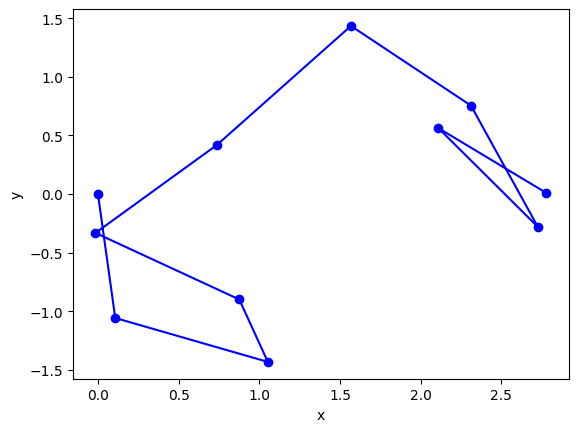

In [2]:
# testing a single walk
from lib import walk, delta

asterix = [0,0]
path = []
path.append (asterix)
print (asterix)
for i_step in range (N_steps_galois): path.append (walk (1, path[-1]))

fig, ax = plt.subplots ()
ax.plot ([x for x,y in path], [y for x,y in path], 'bo-')
ax.set_xlabel ('x')
ax.set_ylabel ('y')
plt.show ()    

 * Si consideri ora l'intera popolazione: si determini la posizione $(x,y)$ di ogni abitante dopo $N=10$ passi a partire dal calderone e si disegni le distribuzione della distanza raggiunta dal punto di partenza, assumendo la popolazione totale composta da 10000 persone.

In [3]:
from lib import walk, norm

abitanti = []
distanze = []
for galois in range (N_galois):
    abitanti.append (walk (N_steps_galois, [0,0]))

print ('generati', len (abitanti), 'abitanti')

generati 10000 abitanti


In [4]:
distanze = [delta(galois) for galois in abitanti]

(array([ 86., 260., 393., 554., 741., 782., 788., 788., 816., 794., 669.,
        654., 582., 485., 397., 327., 251., 202., 139.,  95.,  69.,  51.,
         32.,  17.,   9.,   8.,   7.,   1.,   2.,   1.,   0.,   0.]),
 array([ 0.    ,  0.3125,  0.625 ,  0.9375,  1.25  ,  1.5625,  1.875 ,
         2.1875,  2.5   ,  2.8125,  3.125 ,  3.4375,  3.75  ,  4.0625,
         4.375 ,  4.6875,  5.    ,  5.3125,  5.625 ,  5.9375,  6.25  ,
         6.5625,  6.875 ,  7.1875,  7.5   ,  7.8125,  8.125 ,  8.4375,
         8.75  ,  9.0625,  9.375 ,  9.6875, 10.    ]),
 <BarContainer object of 32 artists>)

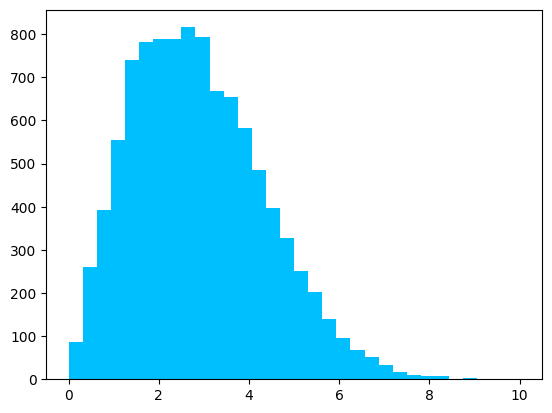

In [5]:
from lib import sturges

N_bins = sturges (len (distanze))
h_max = np.ceil (max (distanze))
# build a numpy histogram containing the data counts in each bin
bin_content, bin_edges = np.histogram (distanze, bins = N_bins, range = (0, h_max))

fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.hist (distanze,
         bins = bin_edges,
         color = 'deepskyblue',
        )

 * Si determinino media, varianza, asimmetria e curtosi della distribuzione ottenuta

In [6]:
from stats import stats

stats_calculator = stats (distanze)
print ('mean    :', stats_calculator.mean ())
print ('sigma   :', stats_calculator.sigma ())
print ('skewness:', stats_calculator.skewness ())
print ('kurtosis:', stats_calculator.kurtosis ())


mean    : 2.8814650551609655
sigma   : 1.4632731178815954
skewness: 0.533882203380624
kurtosis: -0.025258812801438157


 * Si mostri graficamente che, se la lunghezza dei passi \`e costante uguale ad 1, la distribuzione delle distanze $r$ dopo $N$ passi segue una distribuzione di Rayleigh:
   \begin{align}
   f(r) = \frac{2r}{N}e^{-r^2/N}
   \end{align}

In [7]:
abitanti_R1 = []
for galois in range (N_galois): abitanti_R1.append (walk (N_steps_galois, [0,0], True))
distanze_R1 = [delta(galois) for galois in abitanti_R1]

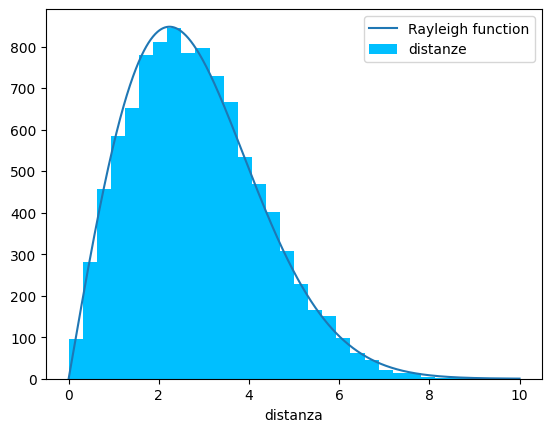

In [8]:
def Rayleigh (r, N_steps, norm):
    return norm * 2 * r * np.exp (-1 * r**2 / N_steps) / N_steps

N_bins = sturges (len (distanze_R1))
h_max = np.ceil (max (distanze_R1))
bin_content, bin_edges = np.histogram (distanze_R1, bins = N_bins, range = (0, h_max))

norm = N_galois * (bin_edges[2] - bin_edges[1])

x_coord = np.linspace (0, h_max, 1000)
y_coord = Rayleigh (x_coord, N_steps_galois, norm)
# for i in range (x_coord.size):
#     y_coord[i] = Rayleigh (x_coord[i], 10000)


fig, ax = plt.subplots (nrows = 1, ncols = 1)
ax.plot (x_coord, y_coord, label='Rayleigh function')
ax.hist (distanze_R1,
         bins = bin_edges,
         color = 'deepskyblue',
         label = 'distanze',
        )
ax.set_xlabel ('distanza')
ax.legend ()

# y_coord_2 = np.arange (0., x_coord.size)
# for i in range (x_coord.size):
#     y_coord_2[i] = func (x_coord[i])



 *  Se la lunghezza dei passi \`e costante uguale ad 1, la distribuzione delle distanze $r$ dopo $N$ passi segue una distribuzione di Rayleigh:
   \begin{align}
   f(r) = \frac{2r}{N}e^{-r^2/N}~.
   \end{align}
   Si utilizzi un fit per determinare, a partire dalla distribuzione di distanze costruita in queste ipotesi, il numero di passi effettuati, sapendo che la distribuzione di Rayleigh è presente in \verb!scipy! come \verb!scipy.stats.rayleigh! e che per ottenere la forma funzionale di interesse per il problema questa distribuzione ha come parametri $\texttt{loc} = 0$ e $\texttt{scale} = \sqrt{N/2}$ (dove N \`e il numero di passi).

In [9]:
from iminuit import Minuit
from scipy.stats import rayleigh
from iminuit.cost import BinnedNLL

# the fitting function
def model (bin_edges, N_steps):
    return rayleigh.cdf (bin_edges, 0, np.sqrt (N_steps/2))

N_events = sum (bin_content)

# the cost function for the fit
my_cost_func = BinnedNLL (bin_content, bin_edges, model)

# the fitting algoritm
my_minuit = Minuit (my_cost_func, 
                    N_steps = h_max) # la stima migliore che si può fare di N_step è la distanza massima

# bounds the following parameters to being positive
#my_minuit.limits['N_signal', 'N_background', 'sigma', 'tau'] = (0, None)

# my_minuit.values['N_galois'] = N_events
# my_minuit.fixed['N_galois'] = True

my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 47.29 (χ²/ndof = 1.5)      │              Nfcn = 20               │
│ EDM = 1.49e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_steps │   10.1    │    0.1    │    -0.1    │    0.1     │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │        N_steps        │
├──────────┼───────────┬───────────┤
│  Error   │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌─────────┬─────────┐
│         │ N_steps │
├─────────┼─────────┤
│ N_steps │  0.0102 │
└─────────┴─────────┘

In [10]:
print ('Value of Q2: ', my_minuit.fval)
print ('Number of degrees of freedom: ', my_minuit.ndof)
from scipy.stats import chi2
print ('associated p-value: ', 1. - chi2.cdf (my_minuit.fval, df = my_minuit.ndof))



Value of Q2:  47.29148050867988
Number of degrees of freedom:  31.0
associated p-value:  0.030732820108364534
